In [21]:
import sys
sys.path.append('../')

import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

from analysis import *

from sklearn.metrics import mean_absolute_error, accuracy_score, balanced_accuracy_score, explained_variance_score, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [22]:
import dft_descriptors.prepocessing as pp
import dft_descriptors.featurisation as ft

In [23]:
df = pd.read_csv("data_csv/Data_test11132021.csv", sep = ',')
# Removing 
vc = df.DOI.value_counts()
doi_above_10 = np.array(vc[vc > 20].index)

indexes = []

for i, row in df.iterrows():
    if row["DOI"] not in doi_above_10:
        indexes.append(i)
        
df = df.drop(indexes)
df = df.reset_index(drop=True)

In [24]:
df2 = pp.preprocess(df)

In [25]:
X, y, DOIs, mechanisms, origins = ft.process_dataframe_dft(df2, data_path="data_csv/")

NoLigand


In [44]:
estimators = [('predictor', RandomForestRegressor())]
pipe = Pipeline(estimators)
metric = mean_absolute_error

# 1. Yields distribution by origin and mechanism

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


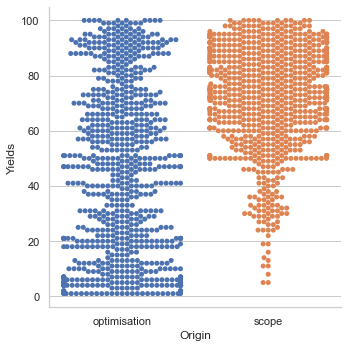

In [45]:
# Yield distribution according to scope/optimization
display_df =  pd.DataFrame(zip(y, mechanisms, origins), columns =['Yields', 'Mechanisms', 'Origin'])

sns.catplot(y="Yields", data=display_df, x='Origin',  kind="swarm")
plt.show()

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 44.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 54.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 42.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anacon

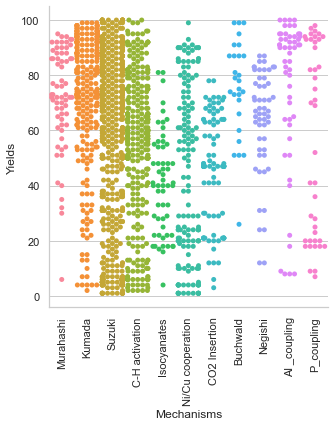

In [46]:
# Yield distribution according to mechanism
chart = sns.catplot(y="Yields", data=display_df, x='Mechanisms',  kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.show()

In [49]:
metric_values, baseline_values, sizes = analysis_train_set_size(X, y, DOIs, metric=metric, predictor=pipe, n_iterations_external=2, n_iterations_internal=4)

In [50]:
metric_mean = np.mean(metric_values, axis=1)
metric_lower = np.percentile(metric_values, 5, axis=1)
metric_upper = np.percentile(metric_values, 95, axis=1)

baseline_mean = np.mean(baseline_values, axis=1)
baseline_lower = np.percentile(baseline_values, 5, axis=1)
baseline_upper = np.percentile(baseline_values, 95, axis=1)

# 2. Evolution of performance with training data availibility

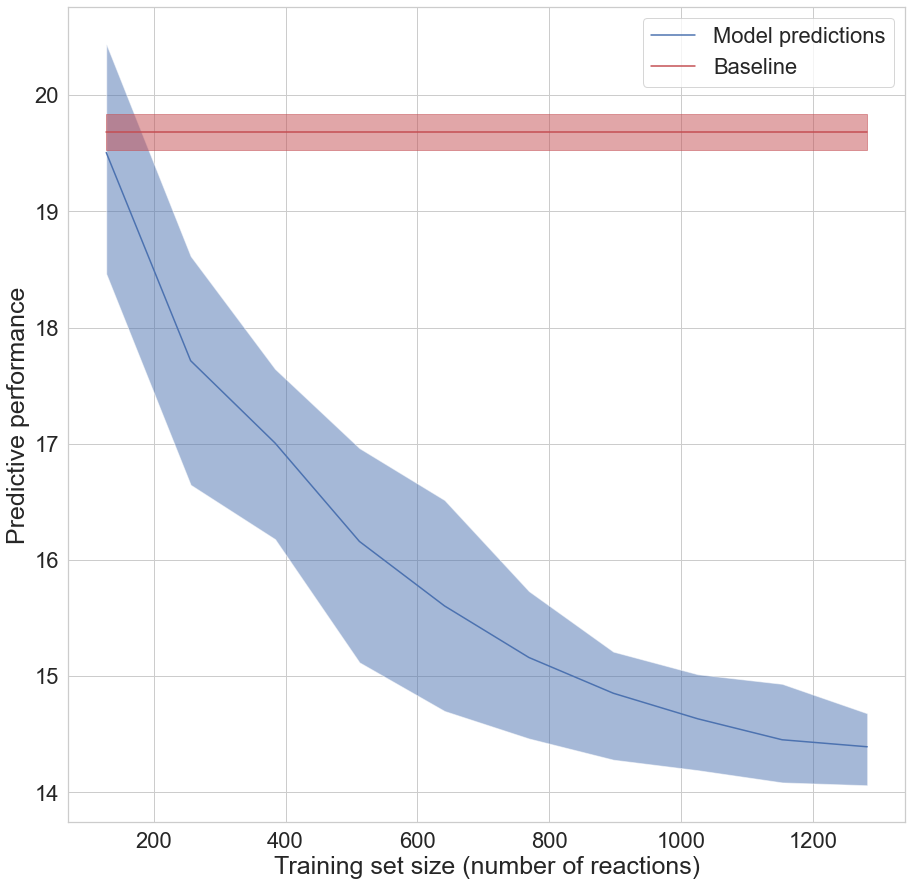

In [51]:
# How does (with fixed test set) performance improves as the training set size augments?
plt.figure(figsize=(15, 15))
plt.plot(sizes, metric_mean, label='Model predictions')
plt.fill_between(sizes, metric_lower, metric_upper, alpha=0.5)

plt.plot(sizes, baseline_mean, c='r', label='Baseline')
plt.fill_between(sizes, baseline_lower, baseline_upper, color='r', alpha=0.5)

plt.xlabel("Training set size (number of reactions)", fontsize=25)
plt.ylabel("Predictive performance", fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.legend(fontsize=22)
plt.savefig("dft_perf_with_training_data_availability_r2.png", dpi=300, format='png', bbox_inches='tight')

In [52]:
metric_standalone, metric_augmented, metric_baseline_standalone, metric_baseline_augmented, unique_stratification, sizes = analysis_stratification_influence(X, y, DOIs, metric=metric, predictor = pipe, test_size=0.95, n_iterations=3)

In [53]:
metric_augmented = np.mean(metric_augmented, axis=1)
metric_standalone = np.mean(metric_standalone, axis=1)
metric_baseline_standalone = np.mean(metric_baseline_standalone, axis=1)


In [54]:
metric_mechanism, metric_augmented_mechanism, metric_baseline_mechanism, _, unique_stratification_mechanism, sizes_mechanism = analysis_stratification_influence(X, y, mechanisms, metric=metric, predictor = pipe, test_size=0.2, n_iterations=3)

In [55]:
metric_augmented_mechanism = np.mean(metric_augmented_mechanism, axis=1)
metric_mechanism = np.mean(metric_mechanism, axis=1)
metric_baseline_mechanism = np.mean(metric_baseline_mechanism, axis=1)

In [56]:
def doi_2_mechanism(DOIs, doi):
    dois_indexes = np.where(DOIs==doi)[0]
    mechanism = mechanisms[dois_indexes[0]]
    return mechanism

def doi_2_origin(DOIs, doi):
    dois_indexes = np.where(DOIs==doi)[0]
    origin = origins[dois_indexes[0]]
    return origin

mecha = [doi_2_mechanism(DOIs, x) for x in unique_stratification]
orig = [doi_2_origin(DOIs, x) for x in unique_stratification]

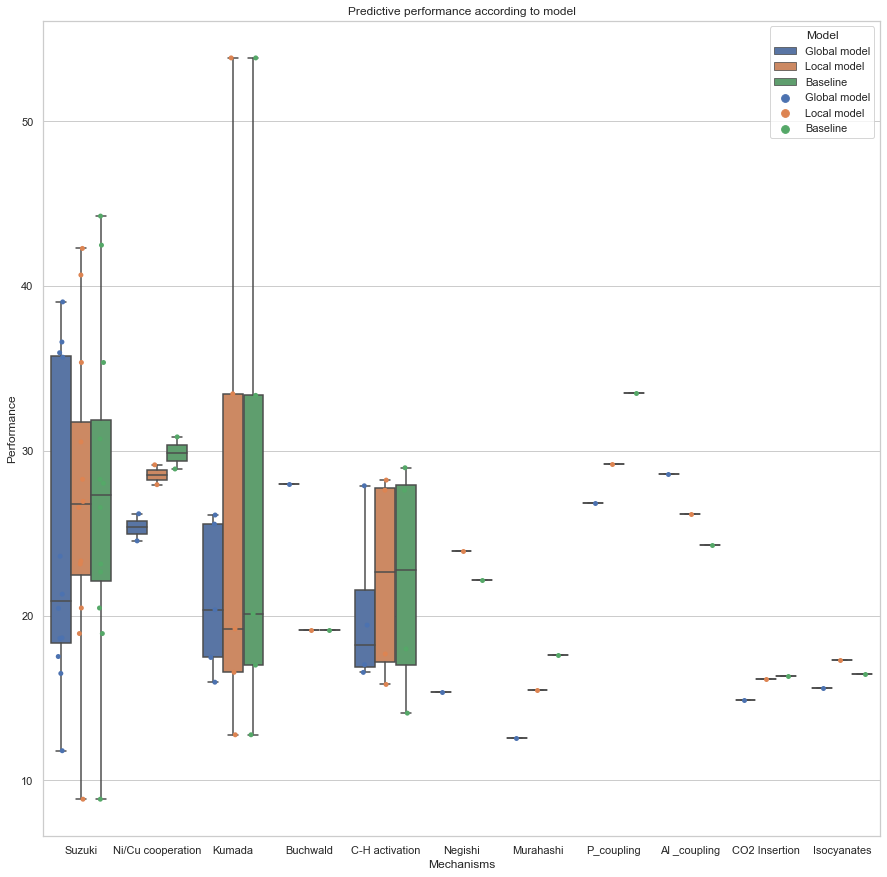

In [57]:
# Comparison of performance (distribution by DOI) of global, local and baseline models, stratified by mechanism

plt.figure(figsize=(15, 15))

global_df = pd.DataFrame(zip(metric_augmented, sizes, unique_stratification, mecha, orig, ["Global model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
local_df = pd.DataFrame(zip(metric_standalone, sizes, unique_stratification, mecha, orig, ["Local model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
baseline_df = pd.DataFrame(zip(metric_baseline_standalone, sizes, unique_stratification, mecha, orig, ["Baseline" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])

display_df = pd.concat([global_df, local_df, baseline_df])

plt.title("Predictive performance according to model")
#plt.ylim(-5, 5)
sns.stripplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)
sns.boxplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)

plt.show()

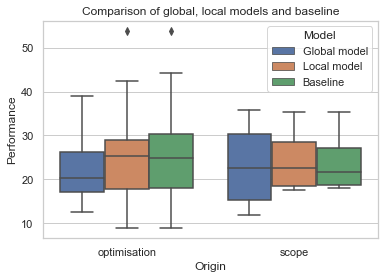

In [58]:
# Comparison of performance (distribution by DOI) of global, local and baseline models, stratified by scope/optimization

plt.title("Comparison of global, local models and baseline")
chart = sns.boxplot(x = "Origin", y="Performance",  data=display_df, hue="Model")

plt.show()

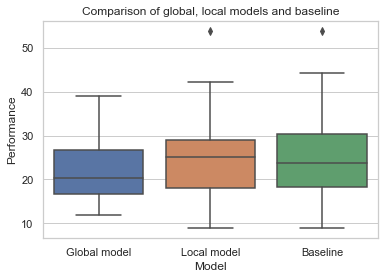

In [59]:
# Comparison of performance (distribution by mechanism) of global, local by mechanism and baseline models 

plt.title("Comparison of global, local models and baseline")
chart = sns.boxplot(x = 'Model', y="Performance",  data=display_df, dodge=True)
plt.show()

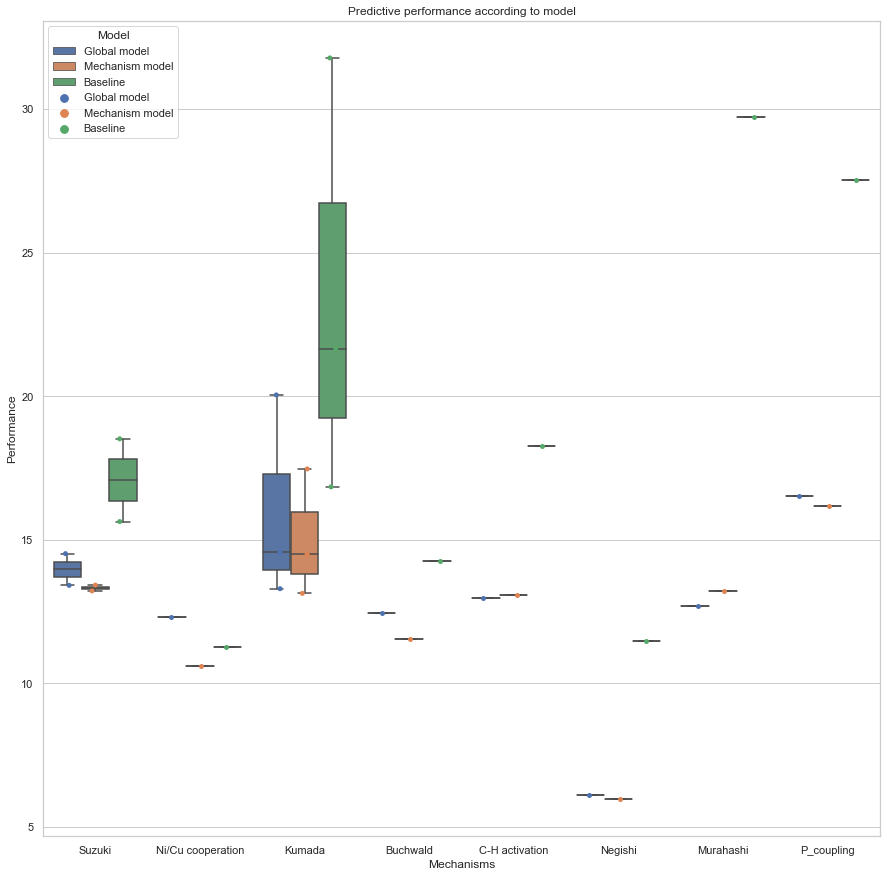

In [60]:
# Comparison of performance (distribution by mechanism) of global, local by mechanism and baseline models, stratified by mechanism

plt.figure(figsize=(15, 15))

global_df = pd.DataFrame(zip(metric_augmented_mechanism, sizes, unique_stratification, mecha, orig, ["Global model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
local_df = pd.DataFrame(zip(metric_mechanism, sizes, unique_stratification, mecha, orig, ["Mechanism model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
baseline_df = pd.DataFrame(zip(metric_baseline_mechanism, sizes, unique_stratification, mecha, orig, ["Baseline" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])

display_df = pd.concat([global_df, local_df, baseline_df])

plt.title("Predictive performance according to model")
#plt.ylim(-5, 5)
sns.stripplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)
sns.boxplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)

plt.show()

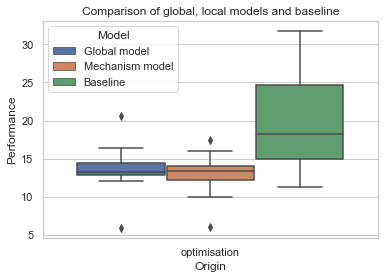

In [22]:
plt.title("Comparison of global, local models and baseline")
chart = sns.boxplot(x = "Origin", y="Performance",  data=display_df, hue="Model")

plt.show()

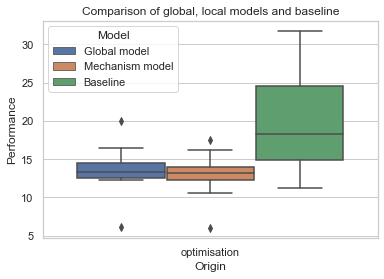

In [61]:
plt.title("Comparison of global, local models and baseline")
chart = sns.boxplot(x = "Origin", y="Performance",  data=display_df, hue="Model")

plt.show()

In [64]:
display_df


,Performance,Size,DOI,Mechanisms,Origin,Model
0,14.517138,48,Thèse,Suzuki,optimisation,Global model
1,12.325115,58,https://doi.org/10.1002/adsc.201600590,Ni/Cu cooperation,optimisation,Global model
2,13.295975,59,https://doi.org/10.1002/anie.200453765,Kumada,optimisation,Global model
3,13.412453,24,https://doi.org/10.1002/anie.200801447,Suzuki,optimisation,Global model
4,12.432914,27,https://doi.org/10.1002/anie.200907287,Buchwald,optimisation,Global model
5,12.985579,88,https://doi.org/10.1002/anie.201403823,C-H activation,optimisation,Global model
6,14.567563,55,https://doi.org/10.1002/chem.201003731,Kumada,optimisation,Global model
7,6.102697,54,https://doi.org/10.1002/chem.201103784,Negishi,optimisation,Global model
8,12.692438,66,https://doi.org/10.1002/chem.201603436,Murahashi,optimisation,Global model
9,20.042015,84,https://doi.org/10.1002/ejic.201900692,Kumada,optimisation,Global model


# 3. Increase of performance compared to baseline, by DOI

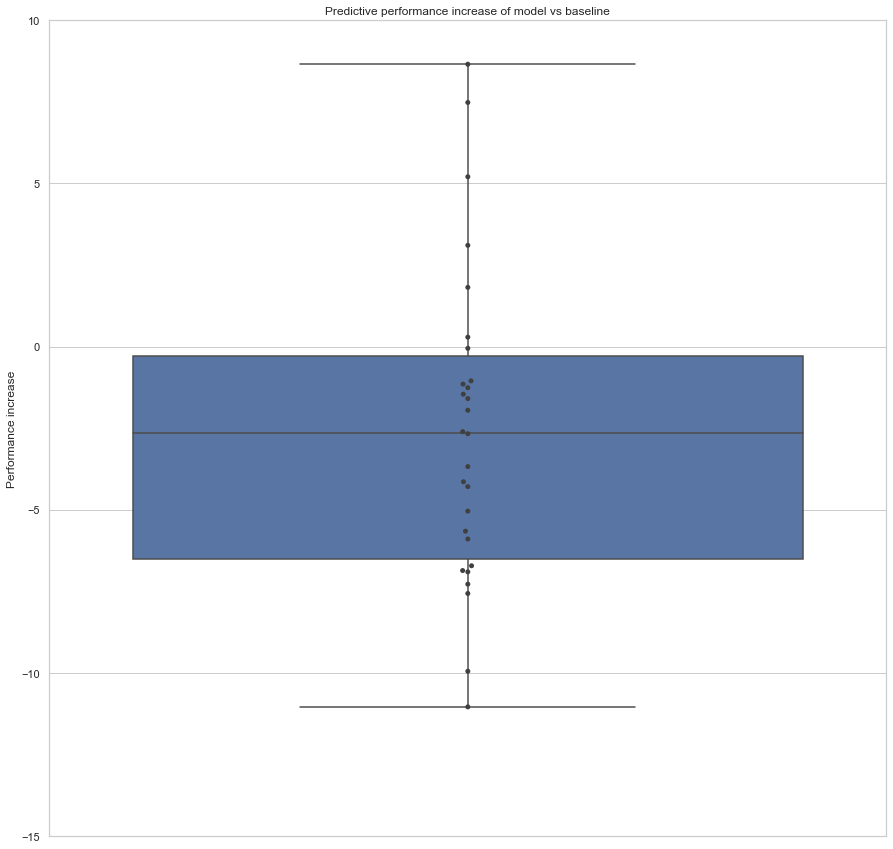

In [23]:
# Distribution of performance increase, global model vs baseline 
plt.figure(figsize=(15, 15))

display_df = pd.DataFrame(metric_augmented-metric_baseline_standalone, columns =['Performance increase'])

plt.title("Predictive performance increase of model vs baseline")
sns.boxplot(y="Performance increase", data=display_df)
sns.swarmplot(y="Performance increase", data=display_df, color=".25")
plt.ylim(-15, 10)
plt.show()

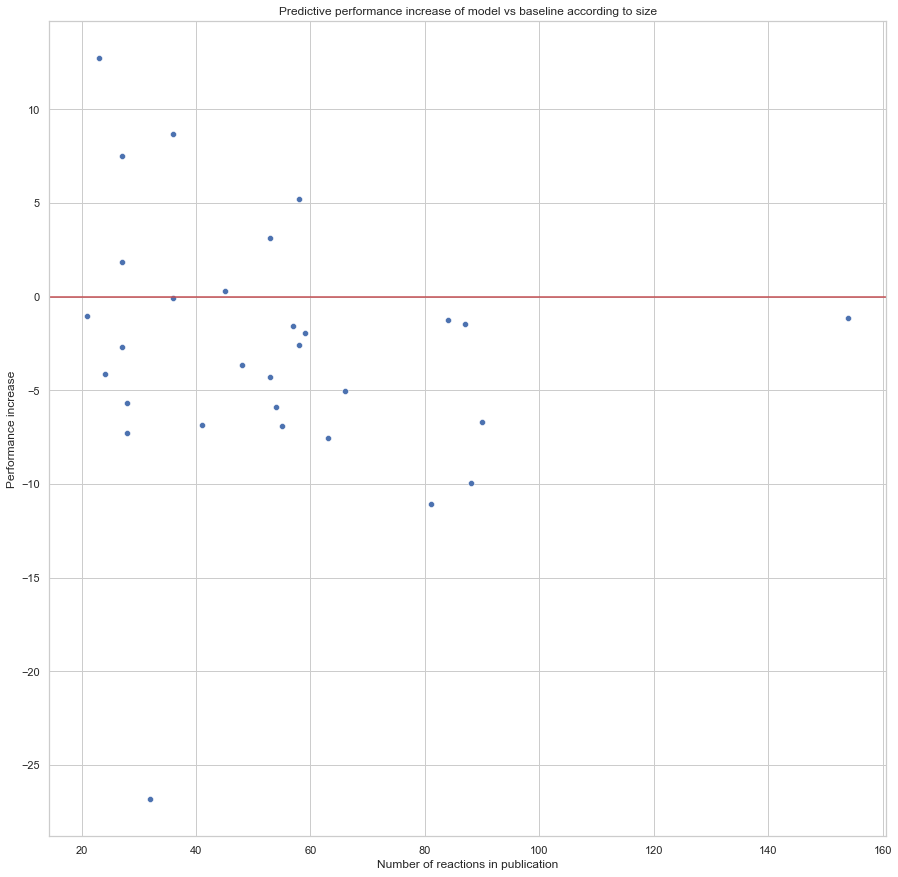

In [24]:
# Distribution of performance increase, global model vs baseline, by size of publication

plt.figure(figsize=(15, 15))

mecha = [doi_2_mechanism(DOIs, x) for x in unique_stratification]
orig = [doi_2_origin(DOIs, x) for x in unique_stratification]

display_df = pd.DataFrame(zip([x for x in metric_augmented-metric_baseline_standalone], sizes, unique_stratification, mecha, orig), columns =['Performance increase', "Size", "DOI", "Mechanisms", "Origin"])

plt.title("Predictive performance increase of model vs baseline according to size")
sns.scatterplot(x="Size", y="Performance increase", data=display_df)
plt.xlabel("Number of reactions in publication")
#plt.ylim(-1, 1.5)
plt.axhline(0, c='r')

plt.show()

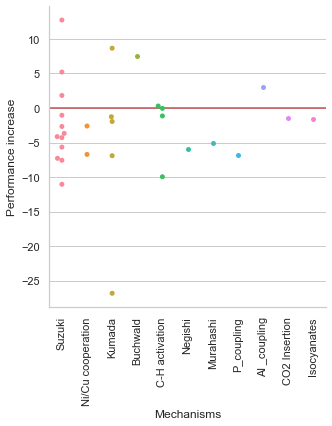

In [25]:
# Distribution of performance increase, global model vs baseline, by mechanism

chart = sns.catplot(x="Mechanisms", y="Performance increase", data=display_df, kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.axhline(0, c='r')
plt.show()

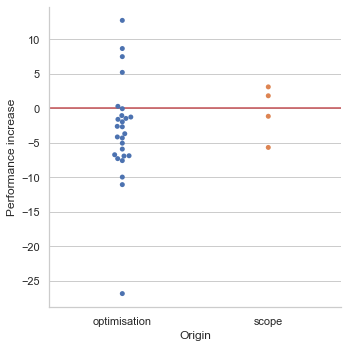

In [26]:
# Distribution of performance increase, global model vs baseline, by scope/optimization

chart = sns.catplot(x="Origin", y="Performance increase", data=display_df, kind="swarm")

plt.axhline(0, c='r')
plt.show()

# 4. Increase of performance compared to local model, by DOI

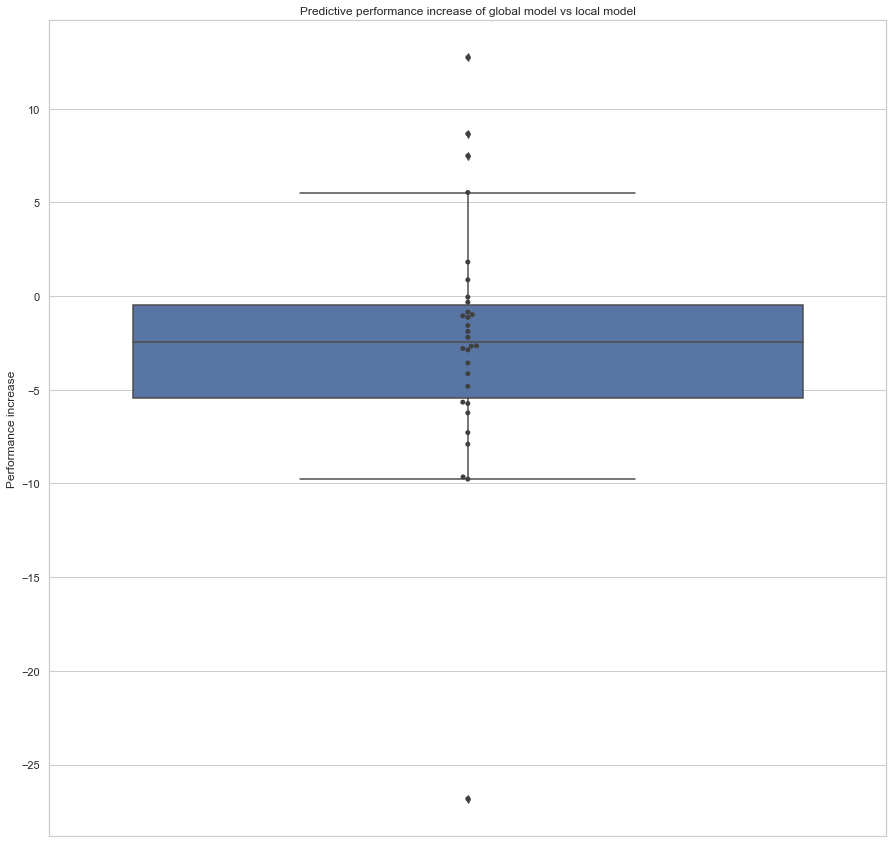

In [27]:
# Distribution of performance increase, global model vs local model

plt.figure(figsize=(15, 15))

display_df = pd.DataFrame(zip([x for x in metric_augmented-metric_standalone], sizes, unique_stratification, mecha, orig), columns =['Performance increase', "Size", "DOI", "Mechanisms", "Origin"])

plt.title("Predictive performance increase of global model vs local model")
sns.boxplot(y="Performance increase", data=display_df)
sns.swarmplot(y="Performance increase", data=display_df, color=".25")

plt.show()

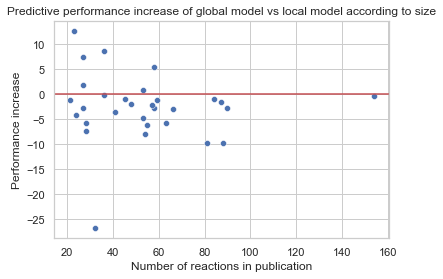

In [28]:
# Distribution of performance increase, global model vs local model, by size of publication

plt.title("Predictive performance increase of global model vs local model according to size")
sns.scatterplot(x="Size", y="Performance increase", data=display_df)
plt.xlabel("Number of reactions in publication")
#plt.ylim(-1, 1.5)
plt.axhline(0, c='r')

plt.show()

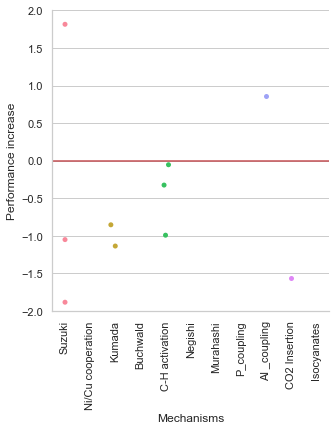

In [29]:
# Distribution of performance increase, global model vs local model, by mechanism

chart = sns.catplot(x="Mechanisms", y="Performance increase", data=display_df, kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.axhline(0, c='r')
plt.ylim(-2, 2)
plt.show()

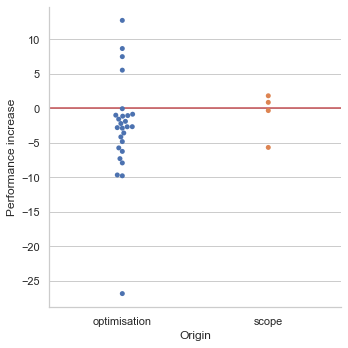

In [30]:
# Distribution of performance increase, global model vs local model, by scope/optimization

chart = sns.catplot(x="Origin", y="Performance increase", data=display_df, kind="swarm")
plt.axhline(0, c='r')
plt.show()

In [31]:
from analysis import analysis_stratification_influence_raw
stratification_results, additional_stratification_results, local_results, global_results, local_baseline_results, values = analysis_stratification_influence_raw(X, y, DOIs, origins, metric=metric, predictor=pipe,
                                      test_size=0.2, n_iterations=10)

In [32]:
display_df =  pd.DataFrame(zip(stratification_results, additional_stratification_results, local_results, global_results, local_baseline_results, values), columns =['DOI', 'Origin', 'Local model', 'Global model', 'Local baseline', 'Yields'])
display_df

,DOI,Origin,Local model,Global model,Local baseline,Yields
0,Thèse,optimisation,3.57,5.720000,55.684211,12.0
1,Thèse,optimisation,55.22,54.900000,55.684211,50.0
2,Thèse,optimisation,3.57,5.720000,55.684211,28.0
3,Thèse,optimisation,3.57,5.720000,55.684211,1.0
4,Thèse,optimisation,23.07,21.370000,55.684211,1.0
...,...,...,...,...,...,...
3335,https://doi.org/10.1246/cl.2011.913,optimisation,24.95,27.533333,36.045455,37.0
3336,https://doi.org/10.1246/cl.2011.913,optimisation,15.29,14.790000,36.045455,24.0
3337,https://doi.org/10.1246/cl.2011.913,optimisation,29.42,34.555000,36.045455,1.0
3338,https://doi.org/10.1246/cl.2011.913,optimisation,26.61,25.470000,36.045455,1.0


In [33]:
from sklearn.metrics import mean_squared_error
metric = r2_score

Optimisation results: -3.610896008647809
Scope results: -1.9458317654461061


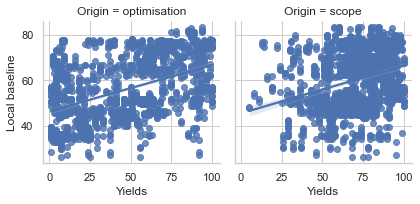

In [34]:
# Results for baseline model
g = sns.FacetGrid(display_df, col="Origin")
g.map(sns.regplot, "Yields", "Local baseline")
indexes = np.where(np.array(additional_stratification_results)=='optimisation')
print("Optimisation results: {}".format(metric(np.array(local_baseline_results)[indexes], np.array(values)[indexes])))
indexes = np.where(np.array(additional_stratification_results)=='scope')
print("Scope results: {}".format(metric(np.array(local_baseline_results)[indexes], np.array(values)[indexes])))

Optimisation results: 0.11641939559732184
Scope results: -1.3383726262427196


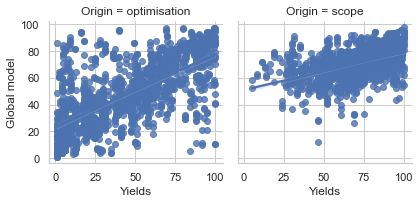

In [35]:
# Results for global model
g = sns.FacetGrid(display_df, col="Origin")
g.map(sns.regplot, "Yields", "Global model")
indexes = np.where(np.array(additional_stratification_results)=='optimisation')
print("Optimisation results: {}".format(metric(np.array(global_results)[indexes], np.array(values)[indexes])))
indexes = np.where(np.array(additional_stratification_results)=='scope')
print("Scope results: {}".format(metric(np.array(global_results)[indexes], np.array(values)[indexes])))

Optimisation results: 0.16912615593518598
Scope results: -0.7564005471872592


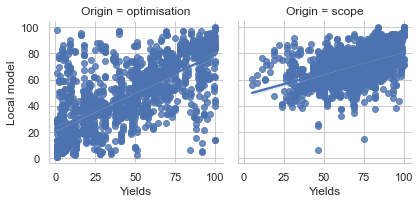

In [36]:
# Results for local models
g = sns.FacetGrid(display_df, col="Origin")
g.map(sns.regplot, "Yields", "Local model")
indexes = np.where(np.array(additional_stratification_results)=='optimisation')
print("Optimisation results: {}".format(metric(np.array(local_results)[indexes], np.array(values)[indexes])))
indexes = np.where(np.array(additional_stratification_results)=='scope')
print("Scope results: {}".format(metric(np.array(local_results)[indexes], np.array(values)[indexes])))

In [65]:
sns.regplot(display_df)

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: regplot inputs must be 1d

In [66]:
display_df

,Performance,Size,DOI,Mechanisms,Origin,Model
0,14.517138,48,Thèse,Suzuki,optimisation,Global model
1,12.325115,58,https://doi.org/10.1002/adsc.201600590,Ni/Cu cooperation,optimisation,Global model
2,13.295975,59,https://doi.org/10.1002/anie.200453765,Kumada,optimisation,Global model
3,13.412453,24,https://doi.org/10.1002/anie.200801447,Suzuki,optimisation,Global model
4,12.432914,27,https://doi.org/10.1002/anie.200907287,Buchwald,optimisation,Global model
5,12.985579,88,https://doi.org/10.1002/anie.201403823,C-H activation,optimisation,Global model
6,14.567563,55,https://doi.org/10.1002/chem.201003731,Kumada,optimisation,Global model
7,6.102697,54,https://doi.org/10.1002/chem.201103784,Negishi,optimisation,Global model
8,12.692438,66,https://doi.org/10.1002/chem.201603436,Murahashi,optimisation,Global model
9,20.042015,84,https://doi.org/10.1002/ejic.201900692,Kumada,optimisation,Global model
